In [9]:
import numpy as np
import networkx as nx

from matplotlib import pyplot as plt
from os import linesep
from typing import List, TypedDict

In [10]:
class QubitPriority:

    def __init__(self, qubit: int, current_node: int, priority: int) -> None:
        self.qubit_id = qubit
        self.current_node = current_node
        self.priority = priority

    def __repr__(self):
        string = f"qubit: {self.qubit_id}" + linesep
        string = string + f"current_node: {self.current_node}" + linesep
        string = string + f"priority: {self.priority}" + linesep + linesep
        return string


class Circuit(nx.Graph):

    def __init__(self, incoming_graph_data=None, **attr):
        super().__init__(incoming_graph_data, **attr)
        self.routes = list()

    def make_grid(self, num_rows: int, num_cols: int) -> None:
        graph = nx.convert_node_labels_to_integers(
            nx.grid_2d_graph(num_rows, num_cols))
        self.add_edges_from(graph.edges)
        self.width = num_cols
        self.length = num_rows
        self.is_grid = True

    def assign_qubits(self, qubits: List) -> None:
        self.node_to_qubit_map = {
            node: qubit
            for node, qubit in enumerate(qubits)
        }

    def route(self):
        PriorityTokenSwap(circuit).route()

    def set_node_coordinates(self, coordinates):
        self.node_coordinates = coordinates

    def get_node_coordinates(self, coordinates=None):
        if coordinates:
            self.node_coordinates = coordinates
        elif not hasattr(self, 'node_coordinates'):
            try:
                if self.is_grid:
                    self.node_coordinates = [
                        (x // self.width, x % self.length)
                        for x in range(self.number_of_nodes())
                    ]
            except:
                self.node_coordinates = [
                    (x, y) for x, y in nx.circular_layout(self).values()
                ]

    def draw(self, coordinates=None, labels=None) -> None:
        self.get_node_coordinates(coordinates)
        positions = self.node_coordinates
        nx.draw_networkx(circuit, pos=positions)
        label_positions = {
            i: (p[0], p[1] + 0.075)
            for i, p in enumerate(positions)
        }
        if not labels:
            labels = self.node_to_qubit_map
        nx.draw_networkx_labels(circuit,
                                pos=label_positions,
                                labels=labels,
                                font_color='red',
                                font_weight='bold')
        plt.show()


class Swap:

    def __init__(self, qubit_priority: QubitPriority) -> None:
        self.qubit = qubit_priority
        self.happy = []
        self.unhappy = []
        self.neutral = []

    def add_swap_candidate(self, happiness, dest):
        if happiness == 2:
            self.happy.append(dest)
        if happiness == 1:
            self.neutral.append(dest)
        if happiness == 0:
            self.unhappy.append(dest)

    def print_possible_swaps(self):
        print("Happy Qbit Swaps:")
        for swap in self.happy:
            print((self.qubit.qubit_id, swap.qubit_id))
        print("Neutral Qbit Swaps:")
        for swap in self.neutral:
            print((self.qubit.qubit_id, swap.qubit_id))
        print("Unhappy Qbit Swaps:")
        for swap in self.unhappy:
            print((self.qubit.qubit_id, swap.qubit_id))


class PriorityTokenSwap:

    def __init__(self, circuit: Circuit) -> None:
        self.circuit = circuit
        self.qubit_priorities = self.find_priorities()
        self.swaps = []

    def find_priorities(self) -> TypedDict:
        qubit_priorities = {}
        for node, qubit in circuit.node_to_qubit_map.items():
            priority = nx.shortest_path_length(circuit, qubit, node)
            qubit_priorities[qubit] = QubitPriority(qubit, node, priority)
        return qubit_priorities

    def find_highest_priority(self):
        highest_priority = max(self.qubit_priorities.values(),
                               key=lambda q: q.priority)
        return highest_priority

    def find_neighbors(self, qubit_priority: QubitPriority) -> List:
        node = qubit_priority.current_node
        canididate_qubits = [
            self.qubit_priorities[self.circuit.node_to_qubit_map[neighbor]]
            for neighbor in circuit.neighbors(node)
        ]
        return canididate_qubits

    def quantify_happines(self, qubit_priority: QubitPriority,
                          neighbor_priority: QubitPriority) -> int:
        qubit = qubit_priority.qubit_id
        qubit_node = qubit_priority.current_node

        neighbor = neighbor_priority.qubit_id
        neighbor_node = neighbor_priority.current_node

        new_qubit_priority = nx.shortest_path_length(self.circuit, qubit,
                                                     neighbor_node)
        new_neighbor_priority = nx.shortest_path_length(
            self.circuit, neighbor, qubit_node)

        if new_qubit_priority + new_neighbor_priority == 0:
            return 2
        if new_qubit_priority + new_neighbor_priority <= qubit_priority.priority + neighbor_priority.priority:
            return 1
        return 0

    def apply_swap(self, swap: Swap):

        def swapping(possible_swaps: List):
            best_swap = None
            for destination in possible_swaps:
                if not best_swap:
                    best_swap = destination
                    continue
                if destination.priority > best_swap.priority:
                    best_swap = destination

            qubit = swap.qubit
            qubit_id = qubit.qubit_id

            best_swap = best_swap
            best_swap_id = best_swap.qubit_id

            # swap the nodes
            qubit_node = best_swap.current_node
            best_swap_node = qubit.current_node
            qubit.current_node = qubit_node
            best_swap.current_node = best_swap_node

            best_swap.priority = nx.shortest_path_length(
                self.circuit, best_swap_id, best_swap_node)
            qubit.priority = nx.shortest_path_length(self.circuit, qubit_id,
                                                     qubit_node)

            self.circuit.node_to_qubit_map[qubit_node] = qubit_id
            self.circuit.node_to_qubit_map[best_swap_node] = best_swap_id

        if swap.happy:
            swapping(swap.happy)
        elif swap.neutral:
            swapping(swap.neutral)
        else:
            swapping(swap.unhappy)

        return

    def route(self):
        labels = {
            v.current_node: (q, v.priority)
            for q, v in self.qubit_priorities.items()
        }
        self.circuit.draw(labels=labels)
        while any(v.priority != 0 for v in self.qubit_priorities.values()):
            swap_qubit = self.find_highest_priority()
            swap = Swap(swap_qubit)
            swap_candidates = self.find_neighbors(swap_qubit)
            for swap_candidate in swap_candidates:
                swap_happiness = self.quantify_happines(
                    swap_qubit, swap_candidate)
                swap.add_swap_candidate(swap_happiness, swap_candidate)
            self.apply_swap(swap)
            labels = {
                v.current_node: (q, v.priority)
                for q, v in self.qubit_priorities.items()
            }

            self.circuit.draw(labels=labels)

*** Node labels are qubit-id and cost (i.e., distance to physical node), respectively. ***


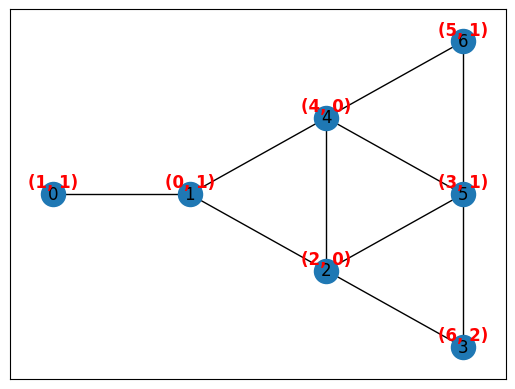

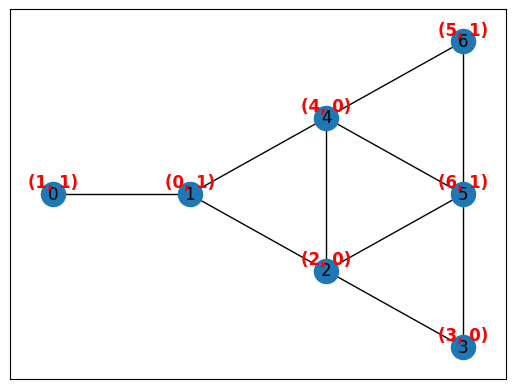

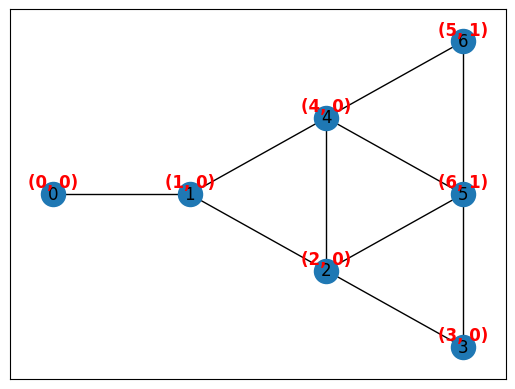

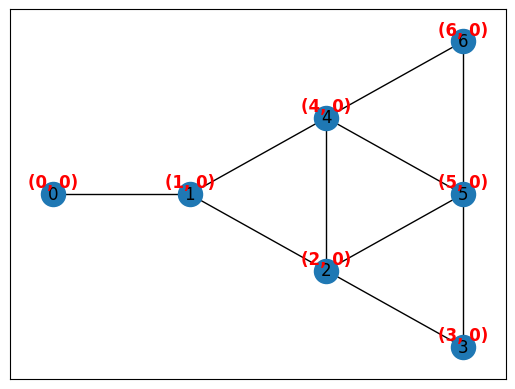

In [17]:
# Working example
edges = [[0, 1], [1, 2], [1, 4], [2, 3], [2, 4], [2, 5], [3, 5], [4, 5],
         [4, 6], [5, 6]]
circuit = Circuit(edges)

qubits = [1, 0, 2, 6, 4, 3, 5]
circuit.assign_qubits(qubits)
positions = [(0, 0), (0.5, 0), (1, -0.5), (1.5, -1), (1, 0.5),
             (1.5, 0), (1.5, 1)]
circuit.set_node_coordinates(positions)
print("*** Node labels are qubit-id and cost (i.e., distance to physical node), respectively. ***")
circuit.route()


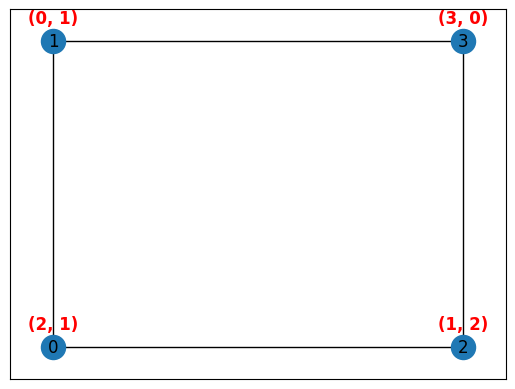

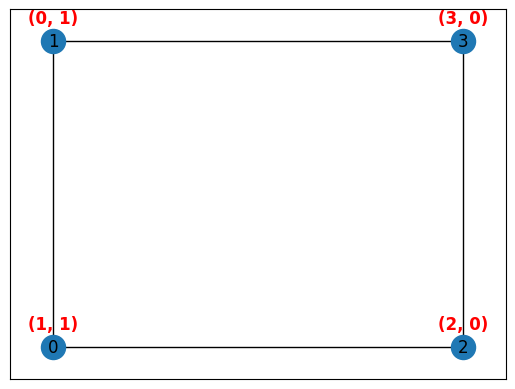

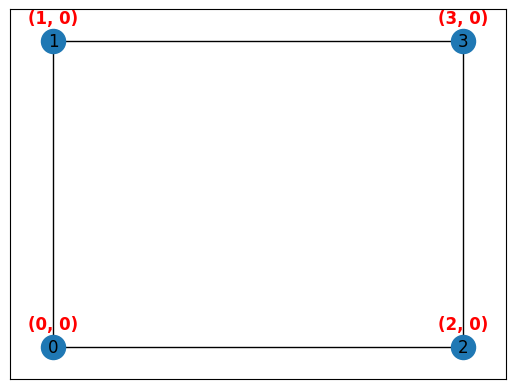

In [12]:
# Simple 2-by-2 grid
circuit = Circuit()
circuit.make_grid(2, 2)

qubits = np.arange(circuit.number_of_nodes())
np.random.shuffle(qubits)

circuit.assign_qubits(qubits)
circuit.route()


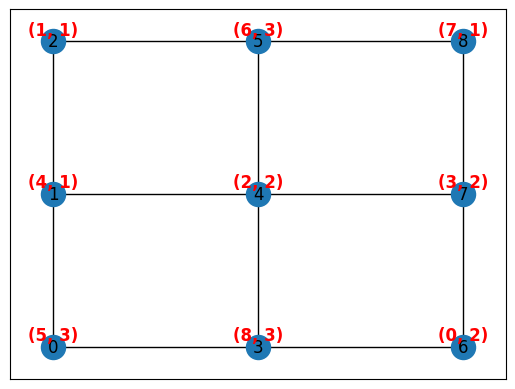

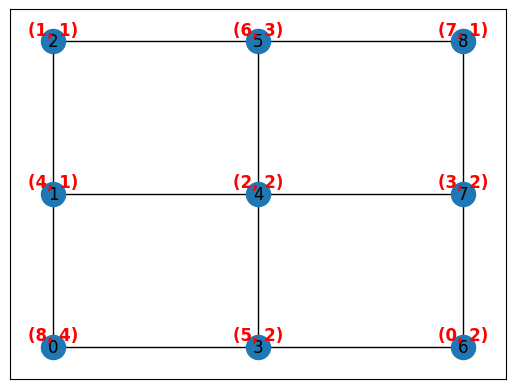

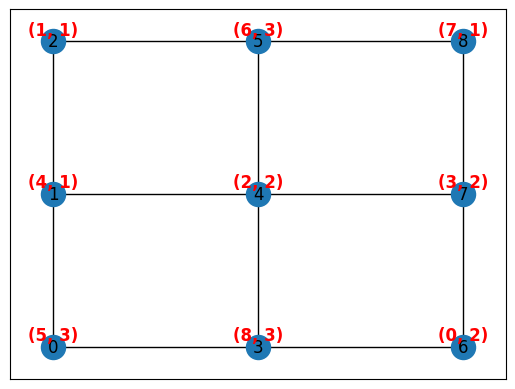

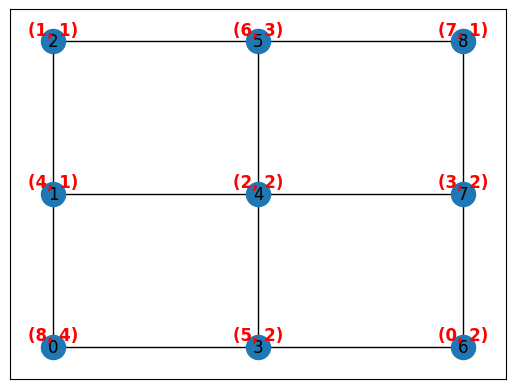

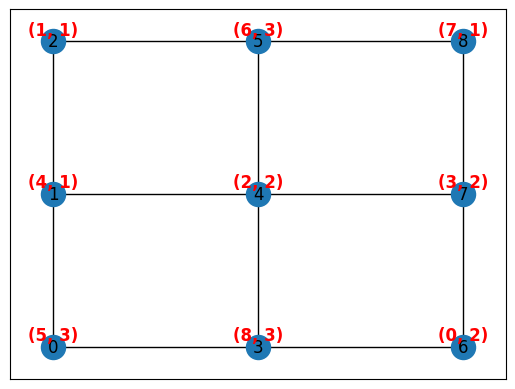

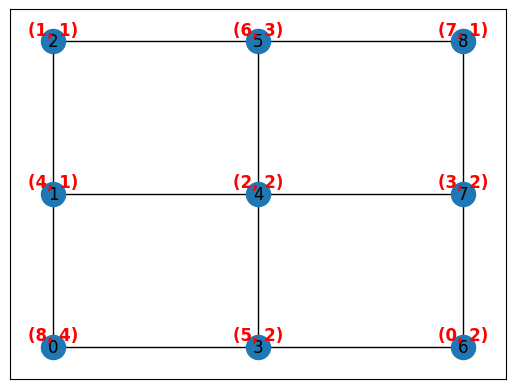

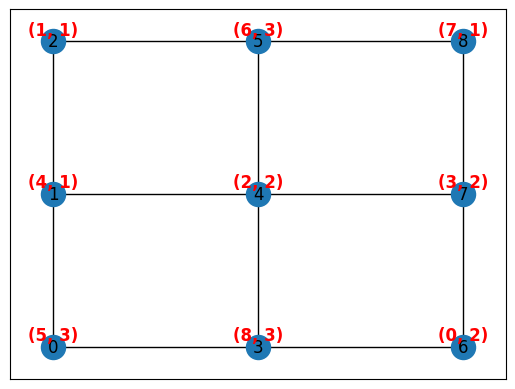

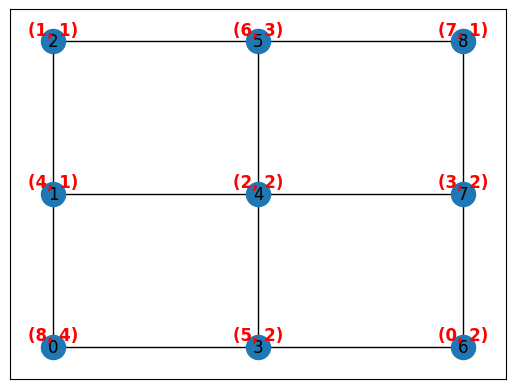

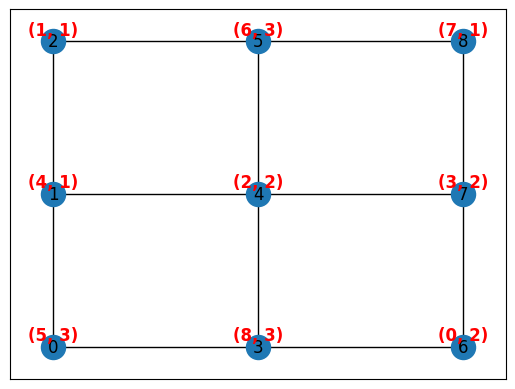

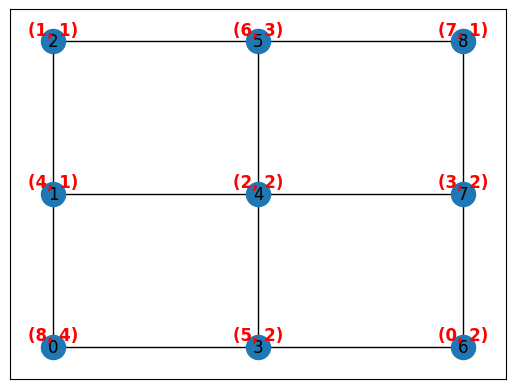

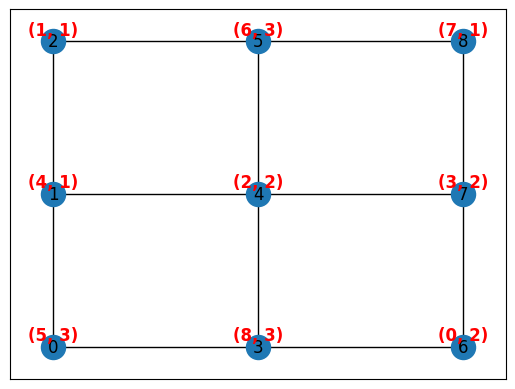

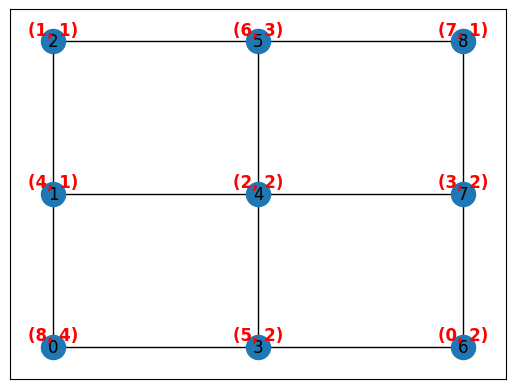

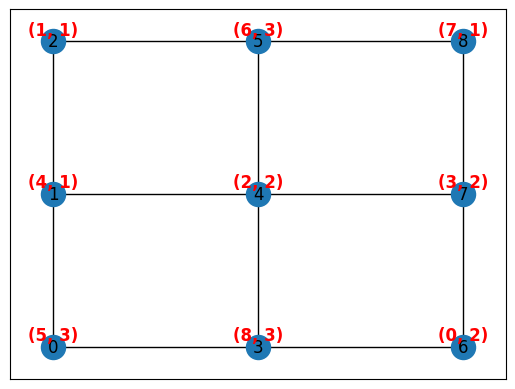

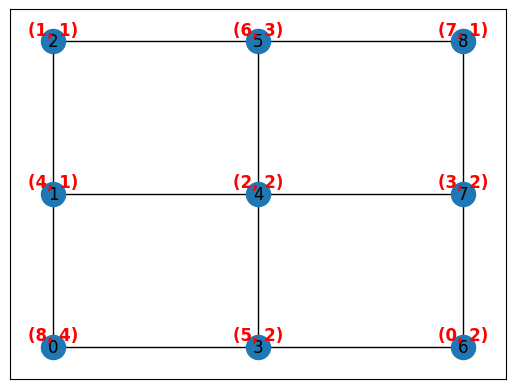

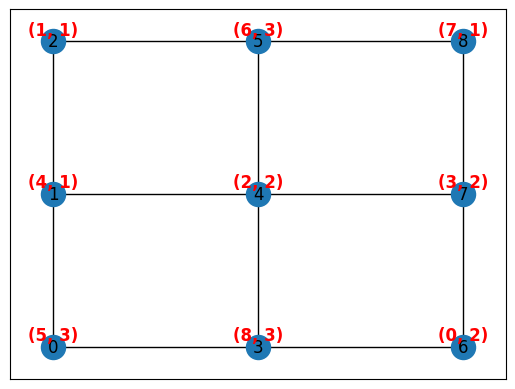

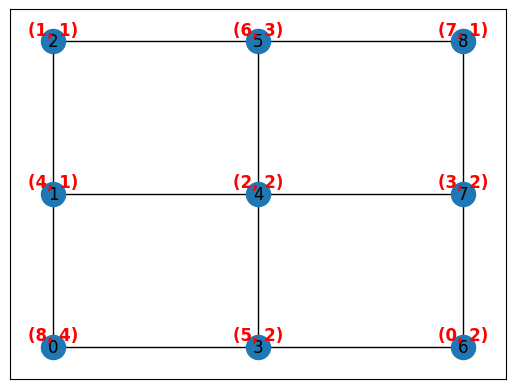

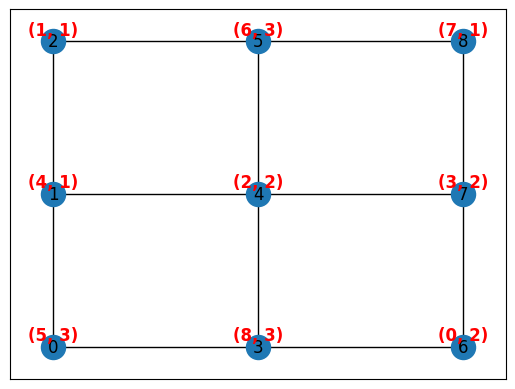

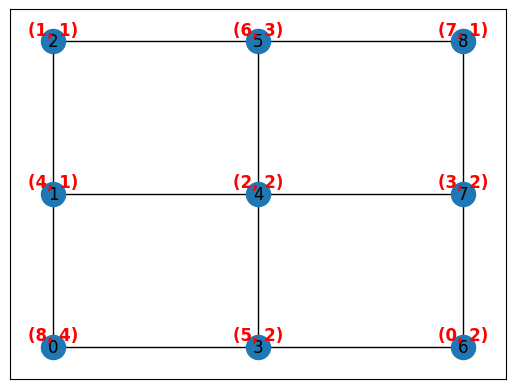

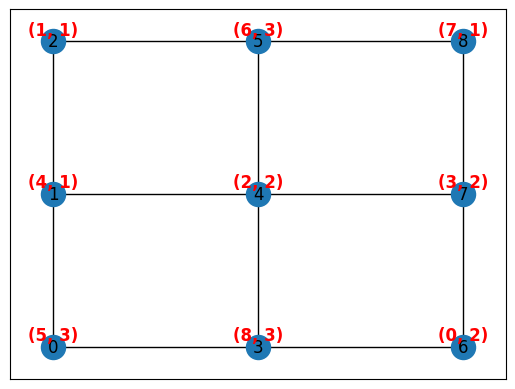

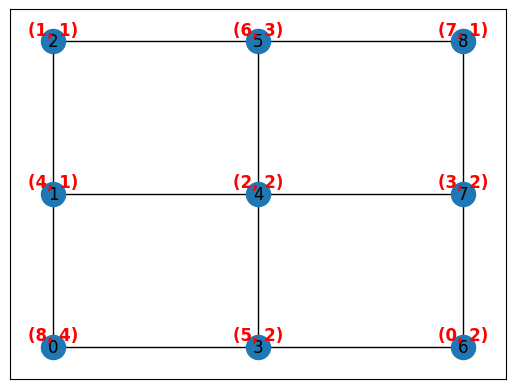

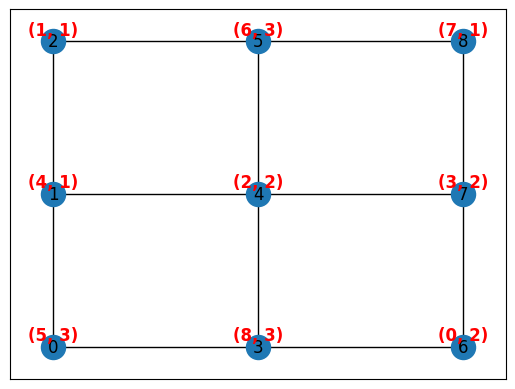

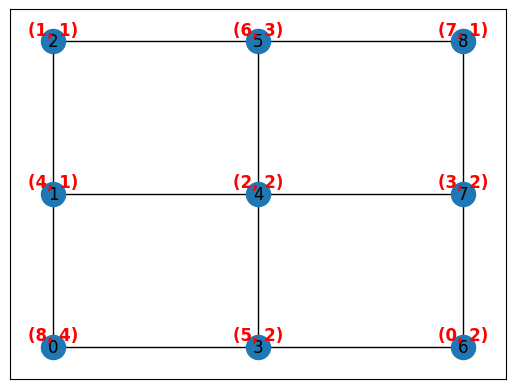

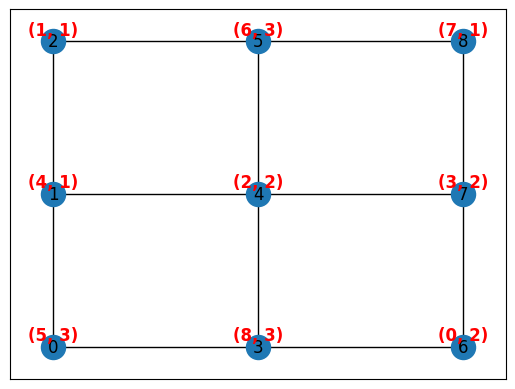

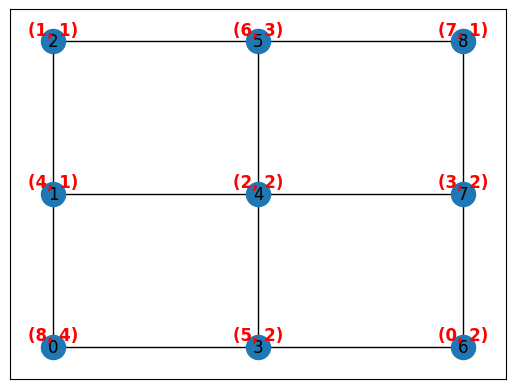

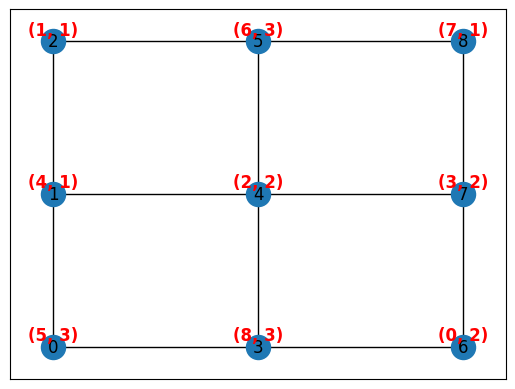

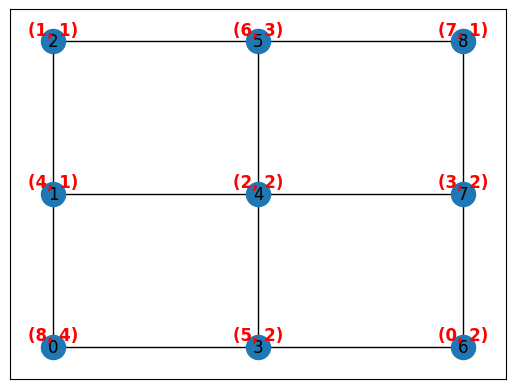

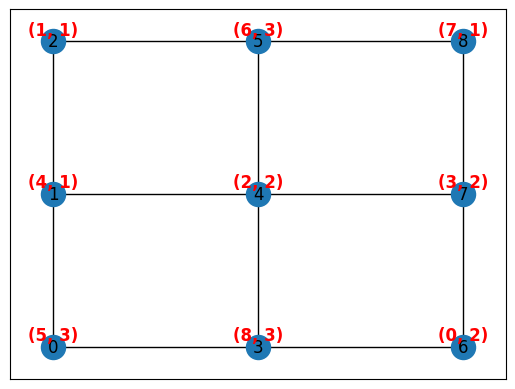

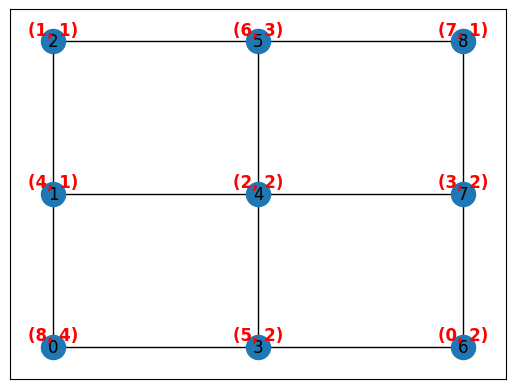

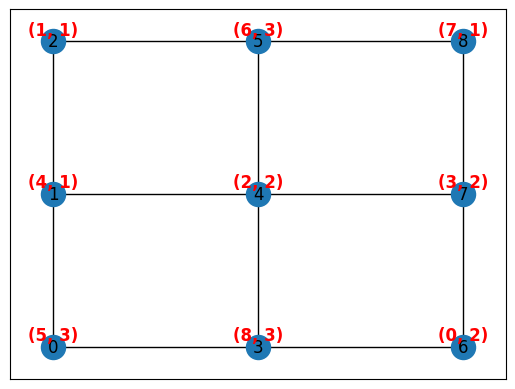

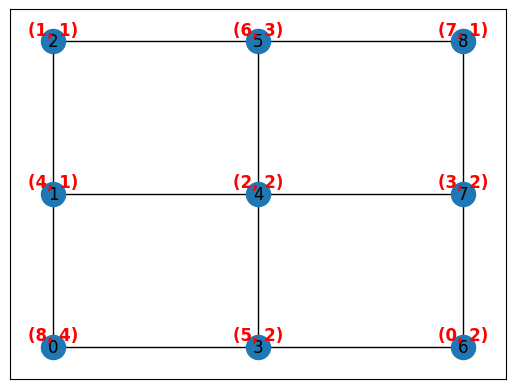

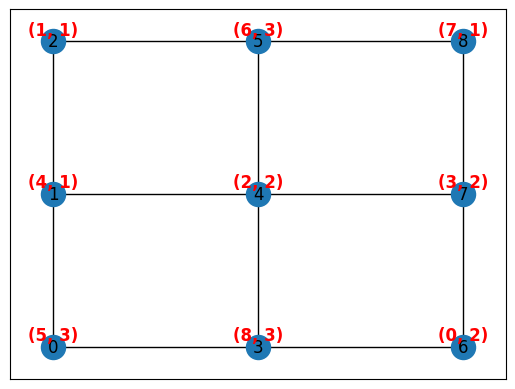

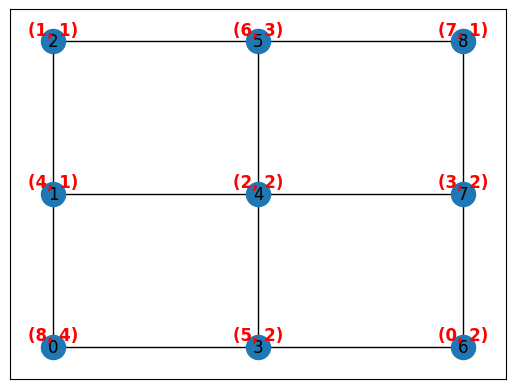

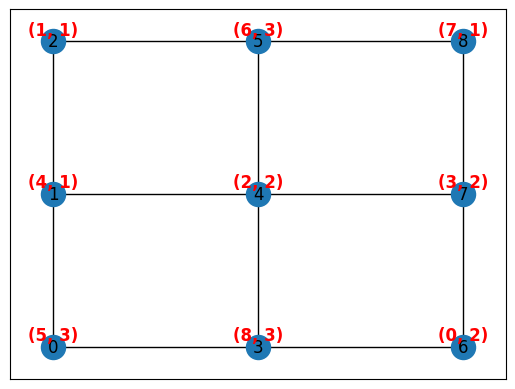

KeyboardInterrupt: 

In [15]:
# Broken example
circuit = Circuit()
circuit.make_grid(3, 3)

qubits = np.arange(circuit.number_of_nodes())
np.random.shuffle(qubits)

qubits = [5, 4, 1, 8, 2, 6, 0, 3, 7]
circuit.assign_qubits(qubits)
circuit.route()